In [1]:
%matplotlib inline
import numpy as np
import scipy 
import matplotlib.pyplot as plt

from scipy.optimize import fsolve
from scipy.optimize import curve_fit
from scipy.integrate import simps
from scipy import interpolate

Falling particle test case
==========================================================


Particle settling chosen to examine correct evaluation and integration of fluid force over the particle.

According to drag law, the frictional force is given by:
$$
F_{D} =\frac{1}{2} \rho_{f} A_{p} C_D \mathbf{v_{r}}^2
$$ 

The difference between weight and buoyancy is:

$$
F_g = \left( m_p - \rho_f V_p \right) g = \left( \rho_p  - \rho_f \right) V_p g = m_r g
$$

Therefore, the net force is:
$$
F_{net} = m_r g - \frac{1}{2} \rho_{f} A_{p} C_D \mathbf{v_{r}}^2
$$

At equilibrium, net force is zero, then:
$$
v_r^{\infty} = \sqrt{\frac{2 m_r g}{\rho_f A C_D}}
$$

The Schiller & Naumann (1933) correlation provides the standard drag coefficient for spherical particles: 

$$
C_D = \max{ \left[ \frac{24}{Re} \left( 1 + 0.15 Re^{0.687} \right), 0.44 \right]}
$$

where the relative particle Reynolds number is given by:

$$
Re = \frac{\rho_{f} \left | {\mathbf{v} - \mathbf{u}} \right | d_{p}}{\mu_{f}} = \frac{\rho_{f} \left | \mathbf{v_r} \right | d_{p}}{\mu_{f}} 
$$

For a spherical particle in the Newtonian drag regime the drag on a sphere can be approximated by a constant, 0.44. This constant value implies that the efficiency of transfer of energy from the fluid to the particle is not a function of fluid velocity. As such the terminal velocity of a particle in a Newtonian regime can again be obtained by equating the drag force to the applied force, resulting in the following expression:

$$
v_r^{\infty} = 2.46 \sqrt{\frac{\left( \rho_p - \rho_f \right) g d_p}{2 \rho_f}}
$$


Test definition
==========================================================



In [2]:
# general properties
g = 9.81 # [m/s²] in positive x direction

# particle properties
d_p = 0.0002 # [m]
rho_s = 2500.0 # [kg/m³]
A_p = np.pi * d_p ** 2.0 / 4.0 # [m²]
V_p = 4.0 / 3.0 * np.pi * (d_p / 2.0) ** 3.0 # [m³]
phi = 0.4341 # [ ]
mass = rho_s * V_p # [kg]

stiff = 100000 # material young's modulus changed to run faster

#fluid properties
rho_air = 1.0 # [kg/m³]
mu_air = 0.00001 # [Pa s]
cartc_time_air = mass/(3*np.pi*mu_air*d_p)

rho_water = 1000 # [kg/m³]
mu_water = 0.001 # [Pa s]
cartc_time_water = mass/(3*np.pi*mu_water*d_p)

#injection properties
len_inj = 0.0002 # [m]
wid_inj = 0.0002 # [m]
time_inj = 0.0001 # [s]
mass_flow_inj = mass/time_inj # [kg/s]
print(mass_flow_inj*1000*60*60, "g/h" )
mass_flow_ton = mass_flow_inj*60*60/1000 #[ton/h]
print(mass_flow_ton, "t/h")


376.9911184307752 g/h
0.0003769911184307752 t/h


In [3]:
# helper functions

def SchillerNaumann1933(Re):
    # calculates CD using SchillerNaumann
    part1 = (24.0/(Re+0.00000001)) * (1 + 0.15 * Re**(0.687))
    part2 = 0.44
    cd = max(part1,part2)
    return cd

def Stokes(Re):
    # calculates CD using Stokes
    cd = 24.0/(Re+0.00000000001)
    return cd

def NewtonianDragTerminalVelocity(rho_s, rho_f, g, d_p):
    # Calculate terminal velocity estimated for a newtonian drag regime
    vel = 2.46 * (((rho_s - rho_f) * g * d_p/2.0 / rho_f)**0.5)
    #vel = (4.0/6)*((rho_s - rho_f) * g * d_p / rho_f * 0.44) 
    return vel

def StokesTerminalVelocity(rho_s, rho_f, g, d_p, mu_f):
    velStokes = (1.0/18)* ( rho_s - rho_f)* g *d_p*d_p/mu_f
    return velStokes

def residual(v_inf):
    Re = rho_f * v_inf * d_p / mu_f
    if regime ==1:
        C_D = SchillerNaumann1933(Re)
    elif regime == 2:
        C_D = Stokes(Re)
    
    delta_v = 0.5 * rho_f * A_p * C_D * v_inf * v_inf - (rho_s - rho_f) * V_p * g
    
    return delta_v

def transient_velocity( vel, time, regime ):
    # Function to calculate velocity against time (to be numerically integrated)
    C1 = (g/rho_s)*(rho_s - rho_f)
    Re = rho_f * vel * d_p / mu_f
    if regime ==1:
        C_D = SchillerNaumann1933(Re)
    elif regime == 2:
        C_D = Stokes(Re)
        
    C2 = (0.5 * rho_f * A_p * C_D / (V_p * rho_s)) 
    return C1 - C2* vel* vel

def find_x_interpolate_given_f(interface, x, t):
    y_array = np.array(x)
    yreduced = y_array - interface
    freduced = interpolate.UnivariateSpline(t, yreduced, s=0)
    time_colision = freduced.roots()
    
    return time_colision

def find_f_interpolate_given_x(x_array, y_array, time):
    f = interpolate.interp1d(x_array, y_array)
    ynew = f(time)
    
    return ynew



In [9]:
# loading the digitized data
rocky_data_one_way = open("falling_particle_1-way_2_phases.csv", 'r')
date_one_way, particlez_one_way, velocity_one_way, displacement_one_way, time_one_way = np.loadtxt(rocky_data_one_way, delimiter = ';', skiprows = 1, unpack = True)    
rocky_data_one_way.close()

rocky_data_one_way = open("falling_particle_2-way_2_phases.csv", 'r')
date_two_way, particlez_two_way, velocity_two_way, displacement_two_way, time_two_way = np.loadtxt(rocky_data_one_way, delimiter = ';', skiprows = 1, unpack = True)    
rocky_data_one_way.close()






Particle falling in air
============

interface 0.00286619 0.00286638
Terminal velocity using Stokes = 5.44782 [m/s] 
Terminal velocity using Newtonian = 3.85170253010276 [m/s] 

 Terminal velocity calculations: 

Particle terminal velocity = 1.91936281045 [m/s] 
Transient velocity calculations: 

0.000276181 [ 0.00027618]
0.000291504 [ 0.0002915] [-0.9997085]


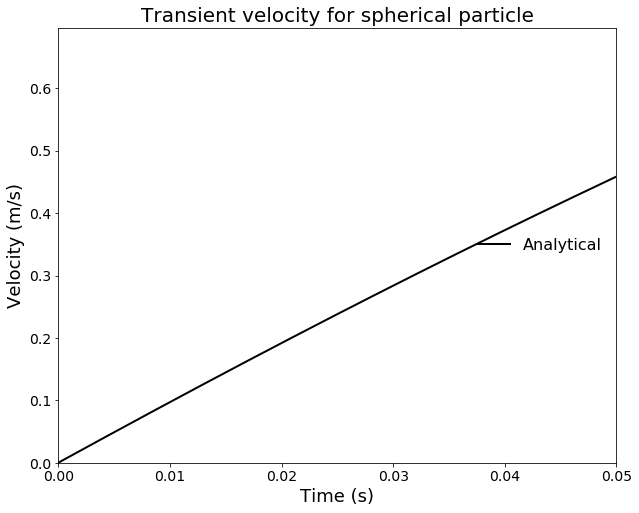

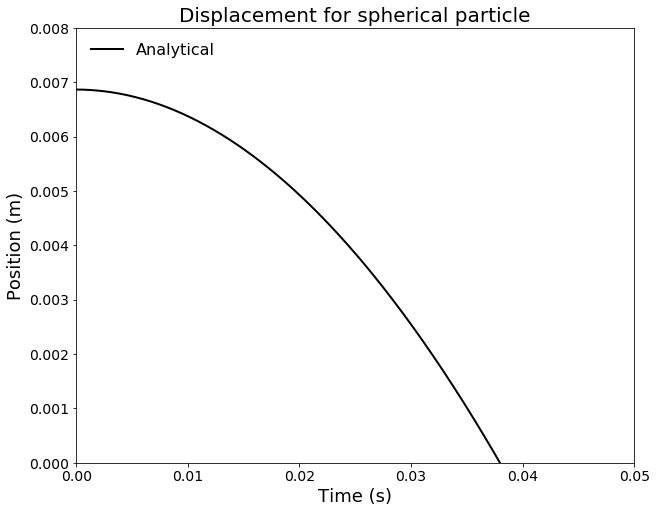

In [10]:
regime = 1
length_domain = 0.008 # [m]
#interface = length_domain/2
initial_height_particle_one_way = particlez_one_way[0] #[m]
initial_height_particle_two_way = particlez_two_way[0] #[m]

interface_one_way = initial_height_particle_one_way-length_domain/2
interface_two_way = initial_height_particle_two_way-length_domain/2
print("interface" , interface_one_way, interface_two_way)
time_total = 0.05
number_iterations = 1000
index = 0

# fluid properties
rho_f = rho_air 
mu_f = mu_air
cartc_time = mass/(3*np.pi*mu_f*d_p)
regime = 1

print("Terminal velocity using Stokes =", StokesTerminalVelocity(rho_s, rho_f, g, d_p, mu_f),  "[m/s] ")
print("Terminal velocity using Newtonian =", NewtonianDragTerminalVelocity(rho_s, rho_f, g, d_p),  "[m/s] ")

print("\n Terminal velocity calculations: \n")
v_inf = fsolve(residual, 0.1)[0]

print("Particle terminal velocity =", v_inf, "[m/s] ")

print("Transient velocity calculations: \n")

initial_time = 0.0
initial_time_one_way = time_one_way[0]
initial_time_two_way = time_two_way[0]
final_time = time_total


#integrating to get velocity
vel_air_one_way = scipy.integrate.odeint(transient_velocity, velocity_one_way[0], time_one_way, (regime,))
vel_air_two_way = scipy.integrate.odeint(transient_velocity, velocity_two_way[0], time_two_way, (regime,))


# define general parameters for plots
plt.rcParams["figure.figsize"] = (10.0, 8.0)
#plt.plot(time_air,vel_air, linewidth = 2, color = "black", label = "Analytical")
plt.plot(time_one_way,vel_air_one_way, linewidth = 2, color = "black", label = "Analytical")

print(velocity_one_way[0], vel_air_one_way[0])
print(velocity_two_way[0], vel_air_two_way[0], vel_air_two_way[0]-velocity_two_way[0]/vel_air_two_way[0])

plt.xlabel('Time (s)',  fontsize = 18)
plt.ylabel('Velocity (m/s)',  fontsize = 18)
plt.title("Transient velocity for spherical particle", fontsize = 20)
plt.legend(fontsize = 16, loc='center right', frameon = False)
plt.xlim(xmax = final_time, xmin = 0)
plt.ylim(ymax = 1.0*vel_air_one_way[-1], ymin = 0)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.savefig('velocity_air.png')
plt.show()


#integrating to get position
#position_air =  scipy.integrate.cumtrapz(vel_air.T, time_air, initial = 0)
position_air_one_way =  scipy.integrate.cumtrapz(vel_air_one_way.T, time_one_way, initial = displacement_one_way[0])
position_air_two_way =  scipy.integrate.cumtrapz(vel_air_two_way.T, time_two_way, initial = displacement_two_way[0])

#plotting position
#plt.plot(time_air, initial_height_particle-position_air.T, linewidth = 2, color = "black", label = "Analytical")
plt.plot(time_one_way, initial_height_particle_one_way-position_air_one_way.T, linewidth = 2, color = "black", label = "Analytical")
plt.xlabel('Time (s)',  fontsize = 18)
plt.ylabel('Position (m)',  fontsize = 18)
plt.title("Displacement for spherical particle", fontsize = 20)
plt.legend(fontsize = 16, loc='upper left', frameon = False)
plt.xlim(xmax = final_time, xmin = 0)
plt.ylim(ymax = length_domain, ymin = 0)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.savefig('displacement_air.png')
plt.show()

Particle falling in air-water domain
==========================================================

colision time is:  0.0243734492822
velocity is:  0.232462640193 0.232470182549
position is:  0.00286619897811 0.00286638913605
1000
Terminal velocity using Stokes = 0.0327 [m/s] 
Terminal velocity using Newtonian = 0.09436593347177782 [m/s] 

 Terminal velocity calculations: 

Particle terminal velocity = 0.0229168303025 [m/s] 
Transient velocity calculations: 



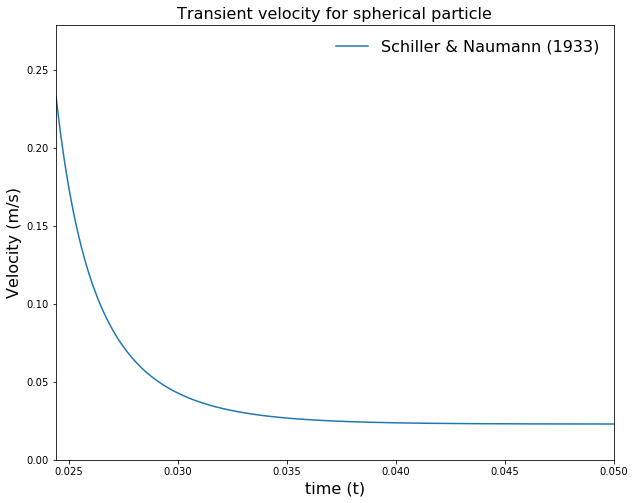

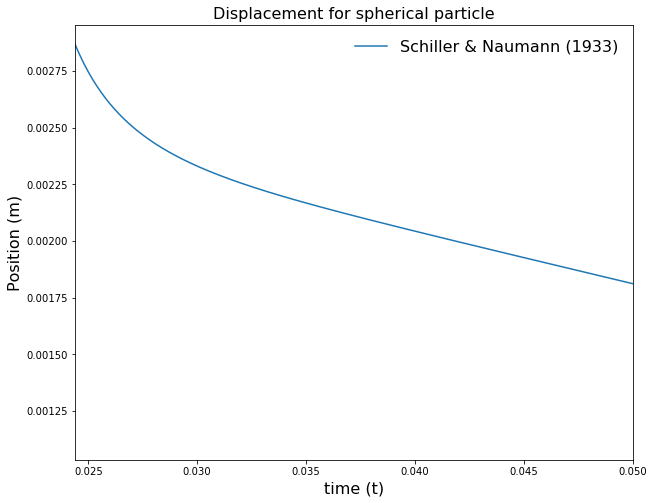

[3, 4, 5]


In [11]:

#colision_time = find_x_interpolate_given_f(interface, position_air, time_air)[0]
colision_time_one_way = find_x_interpolate_given_f(interface_one_way, position_air_one_way, time_one_way)[0]
colision_time_two_way = find_x_interpolate_given_f(interface_two_way, position_air_two_way, time_two_way)[0]

velocity_colision_one_way = find_f_interpolate_given_x(time_one_way, vel_air_one_way.T, colision_time_one_way)[0]
velocity_colision_two_way = find_f_interpolate_given_x(time_two_way, vel_air_two_way.T, colision_time_two_way)[0]

position_colision_one_way = find_f_interpolate_given_x(time_one_way, position_air_one_way, colision_time_one_way)[0]
position_colision_two_way = find_f_interpolate_given_x(time_two_way, position_air_two_way, colision_time_two_way)[0]

print("colision time is: ", colision_time_one_way)  
print("velocity is: ", velocity_colision_one_way, velocity_colision_two_way)
print("position is: ", position_colision_one_way, position_colision_two_way)


# fluid properties
rho_f = rho_water 
mu_f = mu_water 
print(rho_f)

print("Terminal velocity using Stokes =", StokesTerminalVelocity(rho_s, rho_f, g, d_p, mu_f),  "[m/s] ")
print("Terminal velocity using Newtonian =", NewtonianDragTerminalVelocity(rho_s, rho_f, g, d_p),  "[m/s] ")

print("\n Terminal velocity calculations: \n")
v_inf = fsolve(residual, 0.1)[0]

print("Particle terminal velocity =", v_inf, "[m/s] ")

print("Transient velocity calculations: \n")


limited_time_water_one_way = time_one_way[np.argmax(time_one_way>colision_time_one_way):]
limited_time_water_two_way = time_two_way[np.argmax(time_two_way>colision_time_two_way):]

time_water_one_way = np.linspace(colision_time_one_way, final_time, number_iterations)
time_water_two_way = np.linspace(colision_time_two_way, final_time, number_iterations)

#integrating to get velocity
#vel_water = scipy.integrate.odeint(transient_velocity,initial_velocity,time_water, (regime,))

vel_water_one_way = scipy.integrate.odeint(transient_velocity, velocity_colision_one_way, limited_time_water_one_way, (regime,))
vel_water_two_way = scipy.integrate.odeint(transient_velocity, velocity_colision_two_way, limited_time_water_two_way, (regime,))

# define general parameters for plots
plt.rcParams["figure.figsize"] = (10.0, 8.0)
#plt.plot(time_water+colision_time,vel_water, label = "Schiller & Naumann (1933)")
plt.plot(limited_time_water_one_way,vel_water_one_way, label = "Schiller & Naumann (1933)")
plt.xlabel('time (t)',  fontsize = 16)
plt.ylabel('Velocity (m/s)',  fontsize = 16)
plt.title("Transient velocity for spherical particle", fontsize = 16)
plt.legend(fontsize = 16, frameon = False)
plt.ylim(ymax = velocity_colision_one_way*1.2, ymin = 0)
plt.xlim(xmax = final_time, xmin = colision_time_one_way)
plt.show()

#integrating to get position

position_water_one_way =  scipy.integrate.cumtrapz(vel_water_one_way.T,  limited_time_water_one_way, initial = 0) 
position_water_two_way =  scipy.integrate.cumtrapz(vel_water_two_way.T,  limited_time_water_two_way, initial = 0) 

#plt.plot(time_water, position_colision-position_water.T, label = "Schiller & Naumann (1933)")
plt.plot(limited_time_water_one_way, position_colision_one_way-position_water_one_way.T, label = "Schiller & Naumann (1933)")
plt.xlabel('time (t)',  fontsize = 16)
plt.ylabel('Position (m)',  fontsize = 16)
plt.title("Displacement for spherical particle", fontsize = 16)
plt.legend(fontsize = 16, frameon = False)
plt.xlim(xmax = time_total, xmin = colision_time_one_way)
#plt.ylim(ymax = 1.2*position_colision, ymin = 0.8*position_water.T[-1])
plt.show()

a = [3,4,5]
b=[1,2]
print(a)

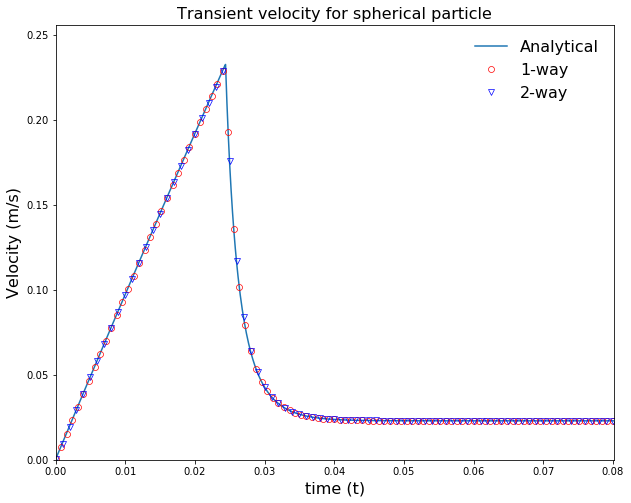

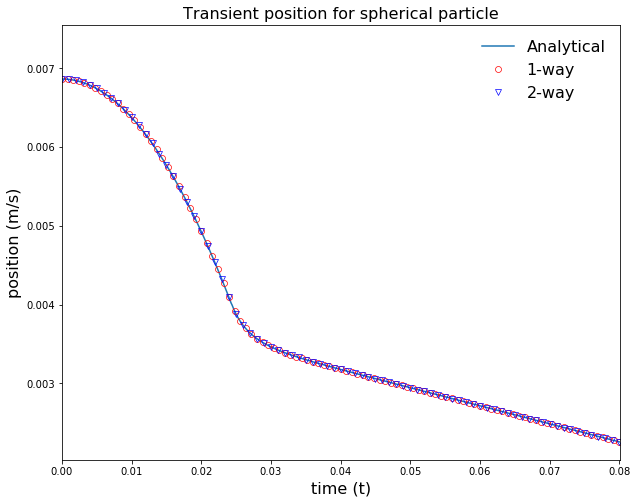

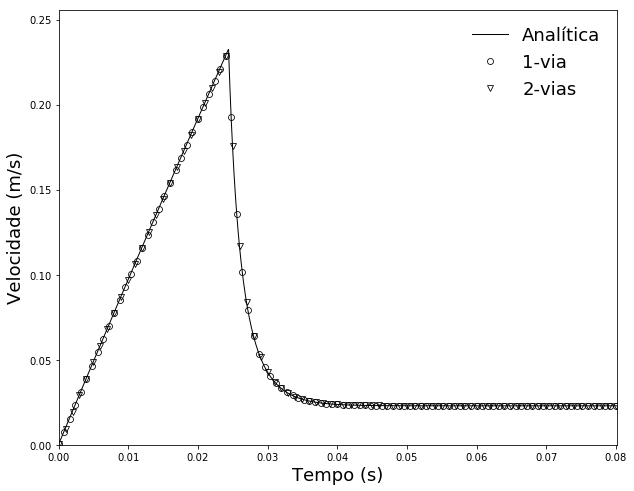

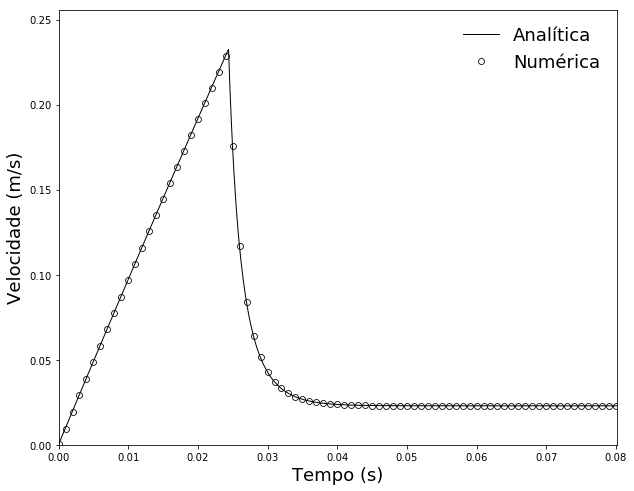

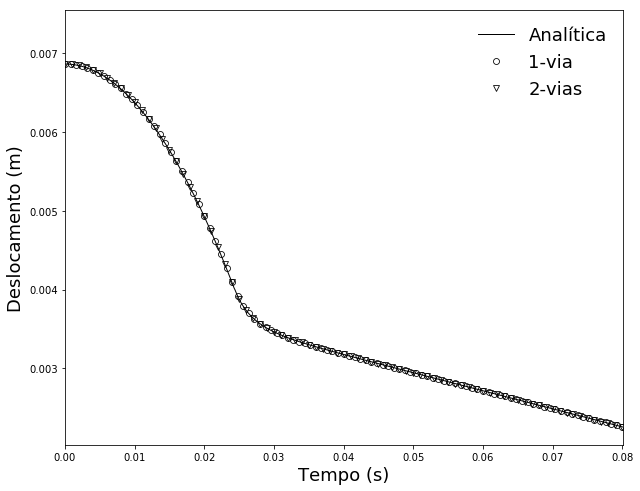

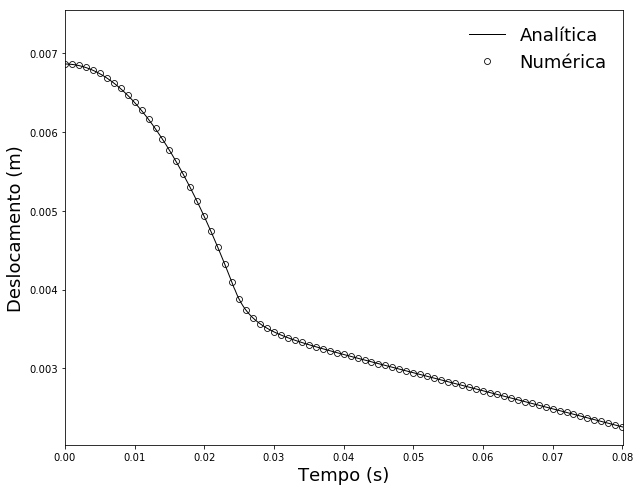

In [14]:
limited_time_air_one_way = time_one_way[0:np.argmax(time_one_way>colision_time_one_way)]
limited_time_air_two_way = time_two_way[0:np.argmax(time_two_way>colision_time_two_way)]

t = np.linspace(0, time_total, number_iterations)
t_one_way = np.append(limited_time_air_one_way, limited_time_water_one_way)
t_two_way = np.append(limited_time_air_two_way, limited_time_water_two_way)
#print(t_one_way)

velocidade_one_way = np.zeros(len(t_one_way))
velocidade_two_way = np.zeros(len(t_two_way))

posicao_one_way = np.zeros(len(t_one_way))
posicao_two_way = np.zeros(len(t_two_way))

count1 = 0
for ind in range(0,len(t_one_way)):      
    if t_one_way[ind] < colision_time_one_way:
        velocidade_one_way[ind] = vel_air_one_way[ind]
        posicao_one_way[ind] = initial_height_particle_one_way-position_air_one_way.T[ind]
        count1 += 1

    else:
        new_index = ind - count1
        velocidade_one_way[ind] = vel_water_one_way[new_index]
        posicao_one_way[ind] = initial_height_particle_one_way-position_colision_one_way-position_water_one_way.T[new_index]
        
count2 = 0
for ind in range(0,len(t_two_way)):      
    if t_two_way[ind] < colision_time_two_way:
        velocidade_two_way[ind] = vel_air_two_way[ind]
        posicao_two_way[ind] = initial_height_particle_two_way-position_air_two_way.T[ind]
        count2 += 1

    else:
        new_index = ind - count2
        velocidade_two_way[ind] = vel_water_two_way[new_index]
        posicao_two_way[ind] = initial_height_particle_two_way-position_colision_two_way-position_water_two_way.T[new_index]        
    
# define general parameters for plots
plt.rcParams["figure.figsize"] = (10.0, 8.0)
plt.plot(t_one_way,velocidade_one_way, label = "Analytical")
plt.plot(time_one_way, velocity_one_way, linestyle = "None", marker = 'o', markeredgecolor = "red",  markeredgewidth = 0.7, markevery=8, 
           markerfacecolor = "none", label = r"1-way")
plt.plot(time_two_way, velocity_two_way, linestyle = "None", marker = 'v', markeredgecolor = "blue",  markeredgewidth = 0.7, markevery=10, 
           markerfacecolor = "none", label = r"2-way")

plt.xlabel('time (t)',  fontsize = 16)
plt.ylabel('Velocity (m/s)',  fontsize = 16)
plt.title("Transient velocity for spherical particle", fontsize = 16)
plt.legend(fontsize = 16, frameon = False)
plt.ylim(ymax = velocity_colision_one_way+velocity_colision_one_way/10, ymin = 0)
plt.xlim(xmax = time_one_way[-1], xmin = 0)
plt.savefig('velocity_air_water.png')
plt.show()

# define general parameters for plots
plt.rcParams["figure.figsize"] = (10.0, 8.0)
plt.plot(t_one_way,posicao_one_way, label = "Analytical")
plt.plot(time_one_way, initial_height_particle_one_way-displacement_one_way, linestyle = "None",  marker = 'o', markeredgecolor = "red", markeredgewidth = 0.7,  
         markevery=8, markerfacecolor = "none", label = r"1-way")
plt.plot(time_two_way, initial_height_particle_two_way-displacement_two_way, linestyle = "None",  marker = 'v', markeredgecolor = "blue", markeredgewidth = 0.7,
         markevery=10, markerfacecolor = "none", label = r"2-way")
plt.xlabel('time (t)',  fontsize = 16)
plt.ylabel('position (m/s)',  fontsize = 16)
plt.title("Transient position for spherical particle", fontsize = 16)
plt.legend(fontsize = 16, frameon = False)
plt.xlim(xmax = time_one_way[-1], xmin = 0)
plt.ylim(ymax = initial_height_particle_one_way*1.1, ymin = 0.9*posicao_one_way[-1])
plt.savefig('position_air_water.png')
plt.show()

# define general parameters for plots
plt.rcParams["figure.figsize"] = (10.0, 8.0)
plt.plot(t_one_way,velocidade_one_way, linewidth = 1, color = "black", label = "Analítica")
plt.plot(time_one_way, velocity_one_way, linestyle = "None", marker = 'o', markeredgecolor = "black",  markeredgewidth = 0.8, markevery=8, 
           markerfacecolor = "none", label = r"1-via")
plt.plot(time_two_way, velocity_two_way, linestyle = "None", marker = 'v', markeredgecolor = "black",  markeredgewidth = 0.8, markevery=10, 
           markerfacecolor = "none", label = r"2-vias")

plt.xlabel('Tempo (s)',  fontsize = 18)
plt.ylabel('Velocidade (m/s)',  fontsize = 18)
#plt.title("Transient velocity for spherical particle", fontsize = 16)
plt.legend(fontsize = 18, frameon = False)
plt.ylim(ymax = velocity_colision_one_way+velocity_colision_one_way/10, ymin = 0)
plt.xlim(xmax = time_one_way[-1], xmin = 0)
plt.savefig('velocidade_air_water.png')
plt.show()

# define general parameters for plots
plt.rcParams["figure.figsize"] = (10.0, 8.0)
plt.plot(t_one_way,velocidade_one_way, linewidth = 1, color = "black", label = "Analítica")
plt.plot(time_one_way, velocity_one_way, linestyle = "None", marker = 'o', markeredgecolor = "black",  markeredgewidth = 0.8, markevery=10, 
           markerfacecolor = "none", label = r"Numérica")

plt.xlabel('Tempo (s)',  fontsize = 18)
plt.ylabel('Velocidade (m/s)',  fontsize = 18)
#plt.title("Transient velocity for spherical particle", fontsize = 16)
plt.legend(fontsize = 18, frameon = False)
plt.ylim(ymax = velocity_colision_one_way+velocity_colision_one_way/10, ymin = 0)
plt.xlim(xmax = time_one_way[-1], xmin = 0)
plt.savefig('velocidade_air_water_1-via.png')
plt.show()

# define general parameters for plots
plt.rcParams["figure.figsize"] = (10.0, 8.0)
plt.plot(t_one_way,posicao_one_way, linewidth = 1, color = "black", label = "Analítica")
plt.plot(time_one_way, initial_height_particle_one_way-displacement_one_way, linestyle = "None",  marker = 'o', markeredgecolor = "black", markeredgewidth = 0.8,  markevery=8, 
           markerfacecolor = "none", label = r"1-via")
plt.plot(time_two_way, initial_height_particle_two_way-displacement_two_way, linestyle = "None",   marker = 'v', markeredgecolor = "black",  markeredgewidth = 0.8, markevery=10, 
           markerfacecolor = "none", label = r"2-vias")
plt.xlabel('Tempo (s)',  fontsize = 18)
plt.ylabel('Deslocamento (m)',  fontsize = 18)
#plt.title("Transient position for spherical particle", fontsize = 16)
plt.legend(fontsize = 18, frameon = False)
plt.xlim(xmax = time_one_way[-1], xmin = 0)
plt.ylim(ymax = initial_height_particle_one_way*1.1, ymin = 0.9*posicao_one_way[-1])
plt.savefig('posicao_air_water.png')
plt.show()

# define general parameters for plots
plt.rcParams["figure.figsize"] = (10.0, 8.0)
plt.plot(t_one_way,posicao_one_way, linewidth = 1, color = "black", label = "Analítica")
plt.plot(time_one_way, initial_height_particle_one_way-displacement_one_way, linestyle = "None",  marker = 'o', markeredgecolor = "black", markeredgewidth = 0.8,  markevery=10, 
           markerfacecolor = "none", label = r"Numérica")
plt.xlabel('Tempo (s)',  fontsize = 18)
plt.ylabel('Deslocamento (m)',  fontsize = 18)
#plt.title("Transient position for spherical particle", fontsize = 16)
plt.legend(fontsize = 18, frameon = False)
plt.xlim(xmax = time_one_way[-1], xmin = 0)
plt.ylim(ymax = initial_height_particle_one_way*1.1, ymin = 0.9*posicao_one_way[-1])
plt.savefig('posicao_air_water_1via.png')
plt.show()

1


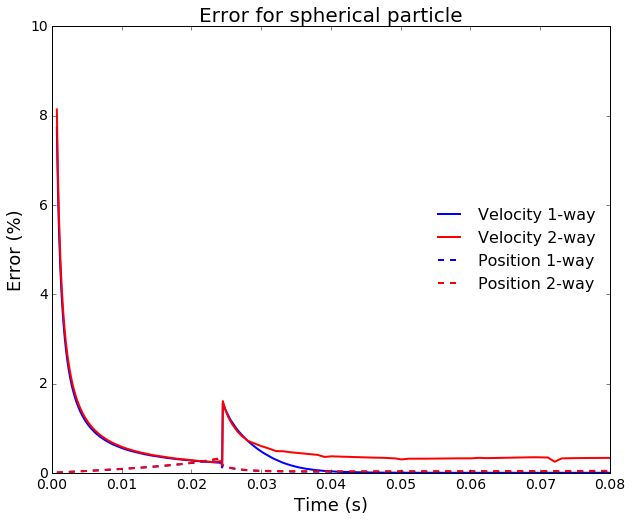

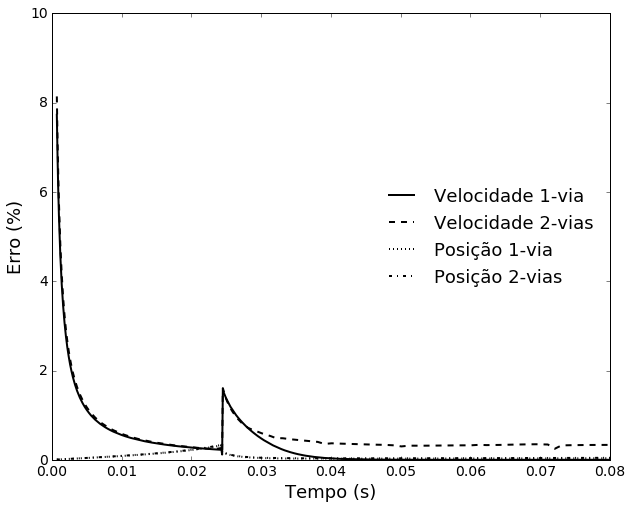

In [15]:
#error calculations

limiting_velocity = v_inf*0.05
print(np.argmax(velocidade_one_way>limiting_velocity))
initial = 7
limited_time_one_way = time_one_way[initial:]
limited_vel_anal_one_way = velocidade_one_way[initial:]
limited_pos_anal_one_way = posicao_one_way.T[initial:]
limited_vel_one_way = velocity_one_way[initial:]
limited_pos_one_way = displacement_one_way[initial:]


limited_time_two_way = time_two_way[initial:]
limited_vel_anal_two_way = velocidade_two_way[initial:]
limited_pos_anal_two_way = posicao_two_way.T[initial:]
limited_vel_two_way = velocity_two_way[initial:]
limited_pos_two_way = displacement_two_way[initial:]


error_vel_1_way = np.absolute(100*(limited_vel_anal_one_way - limited_vel_one_way)/limited_vel_anal_one_way)
#error_vel_1_way = np.absolute(100*(velocidade_one_way - velocidade_one_way)/velocidade_one_way)
error_vel_2_way = np.absolute(100*(limited_vel_anal_two_way - limited_vel_two_way)/limited_vel_anal_two_way)
#error_vel_2_way = np.absolute(100*(velocidade_two_way - velocity_two_way)/velocidade_two_way)

error_pos_1_way = np.absolute(100*(limited_pos_anal_one_way - initial_height_particle_one_way+limited_pos_one_way)/limited_pos_anal_one_way)
error_pos_2_way = np.absolute(100*(limited_pos_anal_two_way - initial_height_particle_two_way+limited_pos_one_way)/limited_pos_anal_two_way)
#error_pos_1_way = np.absolute(100*(posicao_one_way - initial_height_particle_one_way+displacement_one_way)/posicao_one_way)
#error_pos_2_way = np.absolute(100*(posicao_two_way - initial_height_particle_two_way+displacement_two_way)/posicao_two_way)



#plt.plot(time_one_way,error_vel_1_way, linewidth = 2, color = "blue", linestyle= '-', label = "Velocity 1-way")
#plt.plot(time_two_way,error_vel_2_way, linewidth = 2, color = "red", linestyle= '-', label = "Velocity 2-way")
#plt.plot(time_one_way,error_pos_1_way, linewidth = 2, color = "blue", linestyle= '--', label = "Position 1-way")
#plt.plot(time_two_way,error_pos_2_way, linewidth = 2, color = "red", linestyle= '--', label = "Position 2-way")
plt.plot(limited_time_one_way,error_vel_1_way, linewidth = 2, color = "blue", linestyle= '-', label = "Velocity 1-way")
plt.plot(limited_time_two_way,error_vel_2_way, linewidth = 2, color = "red", linestyle= '-', label = "Velocity 2-way")
plt.plot(limited_time_one_way,error_pos_1_way, linewidth = 2, color = "blue", linestyle= '--', label = "Position 1-way")
plt.plot(limited_time_two_way,error_pos_2_way, linewidth = 2, color = "red", linestyle= '--', label = "Position 2-way")
plt.xlabel('Time (s)',  fontsize = 18)
plt.ylabel('Error (%)',  fontsize = 18)
plt.title("Error for spherical particle", fontsize = 20)
plt.legend(fontsize = 16, loc='center right', frameon = False)
#plt.xlim(xmax = time_two_way.max(), xmin = 0)
plt.xlim(xmax = 0.08, xmin = 0)
plt.ylim(ymax = 10, ymin = error_vel_1_way.min())
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.savefig('error_falling_particle_water.png')
plt.show()

plt.plot(limited_time_one_way,error_vel_1_way, linewidth = 2, color = "black", linestyle= '-', label = "Velocidade 1-via")
plt.plot(limited_time_two_way,error_vel_2_way, linewidth = 2, color = "black", linestyle= '--', label = "Velocidade 2-vias")
plt.plot(limited_time_one_way,error_pos_1_way, linewidth = 2, color = "black", linestyle= ':', label = "Posição 1-via")
plt.plot(limited_time_two_way,error_pos_2_way, linewidth = 2, color = "black", linestyle= '-.', label = "Posição 2-vias")
plt.xlabel('Tempo (s)',  fontsize = 18)
plt.ylabel('Erro (%)',  fontsize = 18)
#plt.title("Error for spherical particle", fontsize = 20)
plt.legend(fontsize = 18, loc='center right', frameon = False)
#plt.xlim(xmax = time_two_way.max(), xmin = 0)
plt.xlim(xmax = 0.08, xmin = 0)
plt.ylim(ymax = 10, ymin = 0)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.savefig('erro_particula_na_ar_agua.png')
plt.show()

In [9]:
print(len(limited_time_two_way), len(limited_vel_anal_one_way), len(limited_vel_one_way), len(limited_pos_one_way))

795 795 795 795


In [10]:
print(len(time_two_way), len(velocidade_one_way), len(velocity_one_way), len(displacement_one_way))

802 802 802 802


In [11]:
print(np.argmax(velocidade_one_way>limiting_velocity), np.argmax(velocidade_one_way>limiting_velocity), np.argmax(velocidade_one_way>limiting_velocity), np.argmax(velocity_one_way>limiting_velocity))

1 1 1 2


In [45]:
print(velocidade_one_way[0], velocity_one_way[0] )

0.000276181 0.000276181
